In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from scipy import constants as const

import sys
sys.path.append('C:/Users/naeve/FerDy-Repo/clean_diag/backend')

import trap_units as si
from twod_trap import DoubleTweezer

In [2]:
initial_power = 50* si.uW
initial_waist = 1.1*si.uW
initial_distance = 2*si.um

trap: DoubleTweezer = DoubleTweezer(
    power=0,  # Set pancake laser power to 0, no 2D trap
    grad_z= 0*si.G/si.cm,
    grad_r=0,
    power_tweezer1 = initial_power,     #stationary
    power_tweezer2 = initial_power,     #transfer tweezer
    waist_tweezer1 = initial_waist,     #stationary
    waist_tweezer2 = initial_waist,     #transfer tweezer
    distance_tweezers = initial_distance,

    a=180*(4 * np.pi * const.epsilon_0 * const.value("Bohr radius")**3)/(2 * const.epsilon_0 * const.c),
    wvl = 532 * si.nm,

    g = 0,
)

In [ ]:
n_pot_steps = [30,30,30]
n_levels = 8

left_cutoff = -0.5*initial_distance-2*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])
right_cutoff = 0.5*initial_distance+2*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])
back_cutoff = -2*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])
front_cutoff = 2*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])
bottom_cutoff = -2*np.max([float(trap.subs(trap.get_tweezer_rayleigh1())),float(trap.subs(trap.get_tweezer_rayleigh2()))])
top_cutoff = 2*np.max([float(trap.subs(trap.get_tweezer_rayleigh1())),float(trap.subs(trap.get_tweezer_rayleigh2()))])

extend = [(left_cutoff,right_cutoff),
          (back_cutoff,front_cutoff),
          (bottom_cutoff,top_cutoff)]


# Solve the hamiltonian numerically
energies, states, potential, coords = trap.nstationary_solution(
        [trap.x,trap.y,trap.z], extend, n_pot_steps, k=n_levels)

x = coords[trap.x]
y = coords[trap.y]
z = coords[trap.z]
x3D,y3D,z3D = np.meshgrid(coords[trap.x],coords[trap.y],coords[trap.z],indexing="ij")
pot = potential(x3D,y3D,z3D)

FileNotFoundError: [Errno 2] No such file or directory: 'data/test_3D.npz'

C:\Users\naeve\AppData\Local\Temp\ipykernel_13844\1690377931.py:34: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for c in contour.collections:


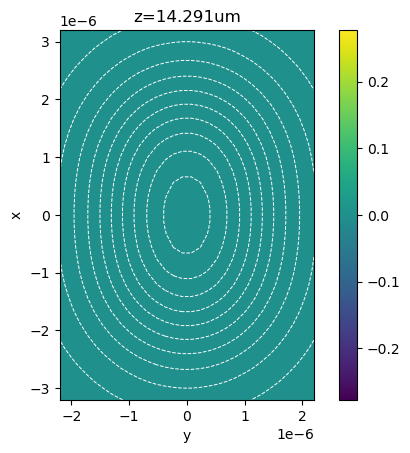

In [7]:
# Generate spatial grid
x = np.linspace(*extend[0], n_pot_steps[0])
y = np.linspace(*extend[1], n_pot_steps[1])
z = np.linspace(*extend[2], n_pot_steps[2])

x3D, y3D, z3D = np.meshgrid(x, y, z,indexing="ij")  # Ensure correct indexing

# Compute potential (Replace with actual function)
pot = potential(x3D, y3D, z3D)

state_number = 2

# Create figure and axis
fig, ax = plt.subplots()
im = ax.imshow(states[state_number, :, :, 0], extent=[*extend[1], *extend[0]], origin="lower",
               vmin=np.min(states[state_number]), vmax=np.max(states[state_number]))

plt.xlabel("y")
plt.ylabel("x")
plt.colorbar(im)

# Initialize contour as None before defining it globally
contour = None

# Animation update function
def update(frame):
    global contour  # Ensure we're modifying the global variable

    im.set_data(states[state_number, :, :, frame])  # Update image data
    ax.set_title(f"z={z[frame]/si.um:.3f}um")  # Update title

    # Remove old contours if they exist
    if contour is not None:
        for c in contour.collections:
            c.remove()

    # Redraw contour plot
    contour = ax.contour(pot[:, :, frame], levels=10, colors='white', linewidths=0.7, extent=[*extend[1], *extend[0]])

# Create the first contour plot after defining update()
contour = ax.contour(pot[:, :, 0], levels=10, colors='white', linewidths=0.7, extent=[*extend[1], *extend[0]])

# Create animation
frames = n_pot_steps[2]  # Number of slices
ani = animation.FuncAnimation(fig, update, frames=frames, interval=100)

ani.save(f"state{state_number}.gif", writer="pillow", fps=10)  # Save as GIF

plt.show()